# Helper Function to Construct the Graph

In [1]:
import pandas as pd
def mapping(data: pd.DataFrame):
    node_id_mapping, inverse_node_id_mapping = dict(), dict()
    for i, node_id in enumerate(data['image_name']):
        node_id_mapping[i] = node_id
        inverse_node_id_mapping[node_id] = i
    return node_id_mapping, inverse_node_id_mapping

In [2]:
import torch
def construct_nodes(data: pd.DataFrame):
    raw_features = data['embedding'].apply(lambda x: (' '.join(x.strip('[').strip(']').strip().split())).split(' '))
    return torch.from_numpy(np.array([[float(val) for val in feature_vector] for feature_vector in raw_features])).to(torch.float32)

In [3]:
from tqdm import tqdm
def construct_edges(features: torch.tensor, threshold: float, method):
    source, target = [], []
    for i in tqdm(range(features.shape[0])):
        for j in range(i + 1, features.shape[0]):
            if method(features[i], features[j]) > threshold:
                source.append(i)
                target.append(j)
                source.append(j)
                target.append(i)
    return torch.tensor([source, target])

In [4]:
def get_labels(data: pd.DataFrame, subject_mapping):
    labels = data['class_name'].apply(lambda x: subject_mapping[x])
    return torch.tensor(labels)

In [5]:
def cosine_similarity(x: torch.tensor, y: torch.tensor):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    return cos(x,y)

def city_block(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=1)

def euclidian(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=2)

# Reading the Data and Exploring

In [6]:
data = pd.read_csv('imagenet_embeddings.csv')

In [7]:
classes = data['class_name'].unique()
subject_mapping = dict()
for i, class_name in enumerate(classes):
    subject_mapping[class_name] = i
subject_mapping

{'lion': 0, 'bear': 1, 'tarantula': 2, 'golden retriever': 3}

In [8]:
import numpy as np
x = construct_nodes(data)
y = get_labels(data, subject_mapping)

In [9]:
def construct_matrix(matrix, method):
    n = matrix.shape[0]
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            similarity_matrix[i][j] = method(matrix[i], matrix[j])
    return similarity_matrix

# Euclidian

In [10]:
euclidian = torch.cdist(x, x, p=2)

# City Block

In [11]:
city_block = torch.cdist(x, x, p=1)

# Max Norm

In [12]:
max_norm = torch.max(torch.abs(x[:, None] - x), dim=2).values

In [ ]:

max_norm.size()

torch.Size([2000, 2000])

# Cosine

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(x)

# BoxPlot

In [101]:
def analysis(class_matrix, class_index: int, subject_mapping: dict):
    classes_names = list(subject_mapping.keys())
    class_dict = dict()
    for name in classes_names:
        class_dict[name] = []
    for i in range(class_matrix.shape[0]):
        relevant_index = list(range(class_index * 500, (class_index+1) * 500))
        same_class_vectors = class_matrix[i][relevant_index]
        class_dict[classes_names[class_index]].append((sum(same_class_vectors) - 1) / (len(same_class_vectors) - 1))
        for j in range(1, 4):
            relevant_index = list(range((class_index - j) * 500, (class_index - j +1) * 500))
            other_class_vectors = [class_matrix[i][k] for k in relevant_index]
            class_dict[classes_names[class_index - j]].append(sum(other_class_vectors) / len(other_class_vectors))
    
    return class_dict

In [134]:
def for_plotting(similarities, subject_mapping: dict):
    scoring_dict = dict()
    averages_dict = dict()
    for i, class_name in tqdm(enumerate(subject_mapping)):
        main_class_vectors = similarities[i * 500 : (i + 1) * 500]
        scoring_dict[class_name] = analysis(main_class_vectors, i, subject_mapping)
    for main_class in subject_mapping.keys():
        averages_dict[main_class] = dict()
        for secondary_class in subject_mapping.keys():
            scores_list = scoring_dict[main_class][secondary_class]
            averages_dict[main_class][secondary_class] = sum(scores_list) / len(scores_list)
    
    return scoring_dict, averages_dict

In [135]:
scoring_dict, averages_dict = for_plotting(euclidian, subject_mapping)

4it [00:21,  5.46s/it]


In [136]:
averages_dict['lion'], averages_dict['bear'], averages_dict['tarantula'], averages_dict['golden retriever']

({'lion': tensor(0.7592),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 {'lion': tensor(0.7998),
  'bear': tensor(0.7784),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7888),
  'golden retriever': tensor(0.8637)},
 {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7517)})

100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


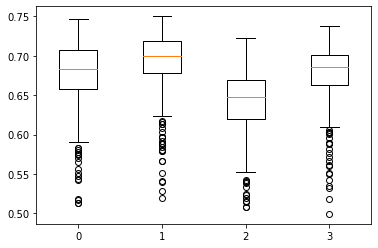

In [257]:
import matplotlib.pyplot as plt

cosine_test = for_box_plots(similarities)
plt.boxplot(cosine_test[0], positions=range(len(cosine_test[0])))
plt.show()

100%|██████████| 4/4 [00:30<00:00,  7.70s/it]


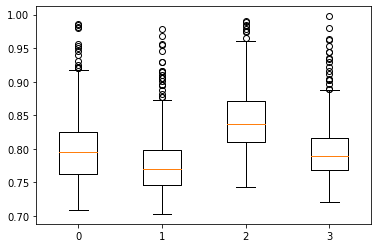

In [282]:
euclidian_test = for_box_plots(euclidian)
plt.boxplot(euclidian_test[0], positions=range(len(euclidian_test[0])))
plt.show()

In [309]:
np.percentile(euclidian_test[0][3], [10, 50, 90])

array([0.75297491, 0.78933421, 0.84796432])

100%|██████████| 4/4 [00:27<00:00,  6.78s/it]


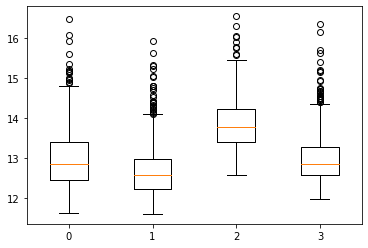

In [283]:
city_block_test = for_box_plots(city_block)
plt.boxplot(city_block_test[0], positions=range(len(city_block_test[0])))
plt.show()

In [284]:
np.percentile(city_block_test[0][3], [10, 50, 90])

array([12.38777609, 12.85571051, 13.79123812])

100%|██████████| 4/4 [00:28<00:00,  7.24s/it]


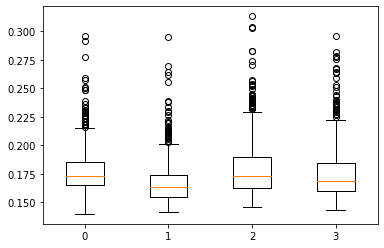

In [297]:
max_norm_test = for_box_plots(max_norm)
plt.boxplot(max_norm_test[0], positions=range(len(max_norm_test[0])))
plt.show()

In [298]:
np.percentile(max_norm_test[0][3], [10, 50, 90])

array([0.15432354, 0.16856233, 0.20794925])

In [260]:
def construct_edges(similarities, lower_threshold, upper_threshold):
    source, target = [], []
    for i in tqdm(range(similarities.shape[0])):
        for j in range(similarities.shape[1]):
            if lower_threshold < similarities[i][j] < upper_threshold and i != j:
                source.append(i)
                target.append(j)
    return torch.tensor([source, target])

In [299]:
edges = construct_edges(max_norm, 0.15, 0.2)

100%|██████████| 2000/2000 [01:02<00:00, 32.05it/s]


# Running GNN

In [156]:
from generate_graph import construct_graph

x, y, edges = construct_graph(pd.read_csv('imagenet_embeddings.csv'), ['euclidian', 0, 0.75])

Constructing Nodes...
Done.
Retrieving Labels...
Done.
Constructing edges based on: euclidian


100%|██████████| 2000/2000 [01:12<00:00, 27.76it/s]


Done, Graph is done constructing.


In [157]:
train_indeces = list(range(0,400)) + list(range(500,900)) + list(range(1000,1400)) + list(range(1500,1900))
valid_indeces = list(range(400,450)) + list(range(900,950)) + list(range(1400,1450)) + list(range(1900,1950))
test_indeces = list(range(450,500)) + list(range(950,1000)) + list(range(1450,1500)) + list(range(1950,2000))

In [158]:
train_mask = torch.tensor([1 if i in train_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if i in valid_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if i in test_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [159]:
from torch_geometric.data import Data

data = Data(x=x, y=y, edge_index=edges, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)

In [160]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//2, normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [161]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels//2, aggr="mean", normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//4, aggr="mean", normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, aggr="mean", normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [162]:
output_dim = len(set(data.y.tolist()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [163]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

In [164]:
def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, valid_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [165]:
best_val_acc = test_acc = 0
for epoch in tqdm(range(1,20)):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 1 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

  5%|▌         | 1/19 [00:06<02:01,  6.74s/it]

Epoch: 001, Val: 0.2400, Test: 0.2450


 11%|█         | 2/19 [00:11<01:31,  5.41s/it]

Epoch: 002, Val: 0.6050, Test: 0.5400


 16%|█▌        | 3/19 [00:15<01:17,  4.85s/it]

Epoch: 003, Val: 0.6050, Test: 0.5400


 21%|██        | 4/19 [00:19<01:08,  4.59s/it]

Epoch: 004, Val: 0.6050, Test: 0.5400


 26%|██▋       | 5/19 [00:23<01:02,  4.48s/it]

Epoch: 005, Val: 0.6050, Test: 0.5400


 32%|███▏      | 6/19 [00:28<00:56,  4.37s/it]

Epoch: 006, Val: 0.6300, Test: 0.6000


 37%|███▋      | 7/19 [00:32<00:54,  4.51s/it]

Epoch: 007, Val: 0.6300, Test: 0.6000


 42%|████▏     | 8/19 [00:38<00:53,  4.85s/it]

Epoch: 008, Val: 0.6300, Test: 0.6000


 47%|████▋     | 9/19 [00:43<00:48,  4.86s/it]

Epoch: 009, Val: 0.6300, Test: 0.6000


 53%|█████▎    | 10/19 [00:48<00:43,  4.84s/it]

Epoch: 010, Val: 0.6650, Test: 0.6500


 58%|█████▊    | 11/19 [00:53<00:38,  4.87s/it]

Epoch: 011, Val: 0.6650, Test: 0.6500


 63%|██████▎   | 12/19 [00:58<00:34,  4.91s/it]

Epoch: 012, Val: 0.6650, Test: 0.6500


 68%|██████▊   | 13/19 [01:03<00:30,  5.00s/it]

Epoch: 013, Val: 0.7250, Test: 0.7050


 74%|███████▎  | 14/19 [01:08<00:25,  5.18s/it]

Epoch: 014, Val: 0.7250, Test: 0.7050


 79%|███████▉  | 15/19 [01:14<00:21,  5.34s/it]

Epoch: 015, Val: 0.7250, Test: 0.7050


 84%|████████▍ | 16/19 [01:19<00:15,  5.22s/it]

Epoch: 016, Val: 0.7550, Test: 0.7200


 89%|████████▉ | 17/19 [01:24<00:10,  5.16s/it]

Epoch: 017, Val: 0.7550, Test: 0.7200


 95%|█████████▍| 18/19 [01:29<00:05,  5.10s/it]

Epoch: 018, Val: 0.7550, Test: 0.7200


100%|██████████| 19/19 [01:34<00:00,  4.97s/it]

Epoch: 019, Val: 0.8350, Test: 0.7650


# Exploration

In [1]:
import pandas as pd
from generate_graph import *
from scores_analysis import *
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
torch_geometric.set_debug(True)

In [2]:
data_df = pd.read_csv('imagenet_embeddings.csv')
x = construct_nodes(data_df)
subject_mapping = get_subject_mapping(data_df)
x.size(), subject_mapping

(torch.Size([2000, 512]),
 {'lion': 0, 'bear': 1, 'tarantula': 2, 'golden retriever': 3})

# Cosine Show Case

In [3]:
from scores_analysis import *
from generate_graph import *

cosine_sim = get_similarities(x, 'cosine')
cosine_scores, cosine_average_scores = scores_dicts(cosine_sim, subject_mapping)

c:\Users\97254\anaconda3\envs\project_lab\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
4it [00:01, 

In [4]:
cosine_average_scores


{'lion': {'lion': 0.706675401509406,
  'bear': 0.6772592098288537,
  'tarantula': 0.6531893964068896,
  'golden retriever': 0.6784711144078972},
 'bear': {'lion': 0.677259209828854,
  'bear': 0.692270173046059,
  'tarantula': 0.6419786516345736,
  'golden retriever': 0.6653905189602377},
 'tarantula': {'lion': 0.6531893964068901,
  'bear': 0.6419786516345735,
  'tarantula': 0.684872404738037,
  'golden retriever': 0.624009262488485},
 'golden retriever': {'lion': 0.6784711144078971,
  'bear': 0.6653905189602378,
  'tarantula': 0.624009262488484,
  'golden retriever': 0.7123907254566412}}

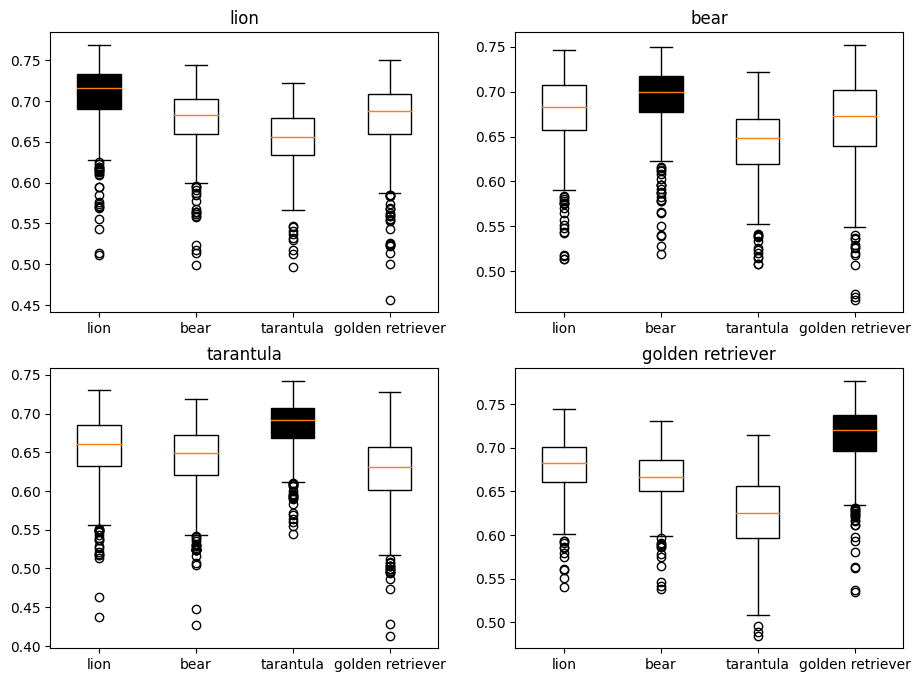

In [5]:
plotting_boxplot(cosine_scores)

In [31]:
cosine_average_scores

{'lion': {'lion': 0.706675401509406,
  'bear': 0.6772592098288537,
  'tarantula': 0.6531893964068896,
  'golden retriever': 0.6784711144078972},
 'bear': {'lion': 0.677259209828854,
  'bear': 0.692270173046059,
  'tarantula': 0.6419786516345736,
  'golden retriever': 0.6653905189602377},
 'tarantula': {'lion': 0.6531893964068901,
  'bear': 0.6419786516345735,
  'tarantula': 0.684872404738037,
  'golden retriever': 0.624009262488485},
 'golden retriever': {'lion': 0.6784711144078971,
  'bear': 0.6653905189602378,
  'tarantula': 0.624009262488484,
  'golden retriever': 0.7123907254566412}}

In [15]:
def get_thresholds(average_scores):
    min_val = float('inf')
    max_val = float('-inf')
    thresholds = []
    for class_name, vals in average_scores.items():
        thresholds.append(vals[class_name])
    for score in thresholds:
        if score > max_val:
            max_val = score
        if score < min_val:
            min_val = score
    thresholds = sorted(thresholds+[min_val*0.95, max_val*1.05])
    return thresholds

In [16]:
get_thresholds(cosine_average_scores)

[0.6506287845011351,
 0.684872404738037,
 0.692270173046059,
 0.706675401509406,
 0.7123907254566412,
 0.7480102617294733]

In [70]:
x, y, edges = construct_graph(data_df, ['cosine', 0.79, 1])

Constructing Nodes...
Done.
Retrieving Labels...
Done.
Constructing edges based on: cosine


100%|██████████| 2000/2000 [00:06<00:00, 290.41it/s]

Done, Graph is done constructing.


# Chord Show Case

In [26]:
chord_sim = get_similarities(x, 'chord')
chord_scores, chord_average_scores = scores_dicts(chord_sim, subject_mapping)
chord_average_scores

c:\Users\97254\anaconda3\envs\project_lab\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
4it [00:32, 

{'lion': {'lion': tensor(0.7612),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 'bear': {'lion': tensor(0.7998),
  'bear': tensor(0.7804),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 'tarantula': {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7908),
  'golden retriever': tensor(0.8637)},
 'golden retriever': {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7537)}}

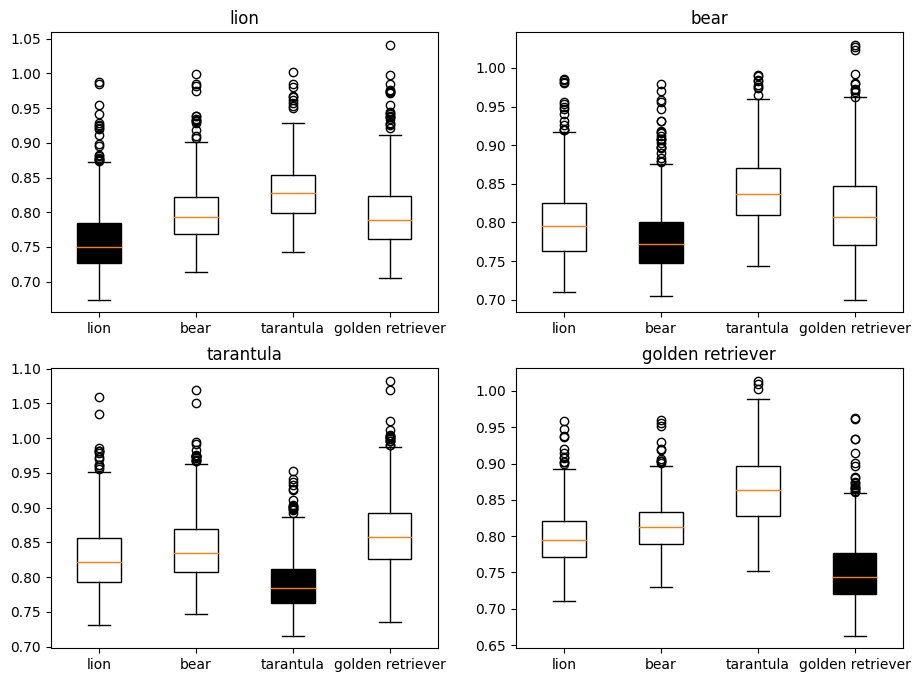

In [20]:
plotting_boxplot(chord_scores)

In [21]:
chord_average_scores

{'lion': {'lion': tensor(0.7612),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 'bear': {'lion': tensor(0.7998),
  'bear': tensor(0.7804),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 'tarantula': {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7908),
  'golden retriever': tensor(0.8637)},
 'golden retriever': {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7537)}}

In [22]:
get_thresholds(chord_average_scores)

[tensor(0.7161),
 tensor(0.7537),
 tensor(0.7612),
 tensor(0.7804),
 tensor(0.7908),
 tensor(0.8303)]

# Eaclidian Show Case

In [28]:
euclidian_sim = get_similarities(x, 'euclidian')
euclidian_scores, euclidian_average_scores = scores_dicts(euclidian_sim, subject_mapping)
# plotting_boxplot(euclidian_scores)
euclidian_average_scores

4it [00:34,  8.65s/it]


{'lion': {'lion': tensor(0.7612),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 'bear': {'lion': tensor(0.7998),
  'bear': tensor(0.7804),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 'tarantula': {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7908),
  'golden retriever': tensor(0.8637)},
 'golden retriever': {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7537)}}

In [24]:
euclidian_average_scores

{'lion': {'lion': tensor(0.7612),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 'bear': {'lion': tensor(0.7998),
  'bear': tensor(0.7804),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 'tarantula': {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7908),
  'golden retriever': tensor(0.8637)},
 'golden retriever': {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7537)}}

In [25]:
get_thresholds(euclidian_average_scores)

[tensor(0.7161),
 tensor(0.7537),
 tensor(0.7612),
 tensor(0.7804),
 tensor(0.7908),
 tensor(0.8303)]

# Max Norm Show Case

c:\Users\97254\anaconda3\envs\project_lab\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
4it [00:51, 

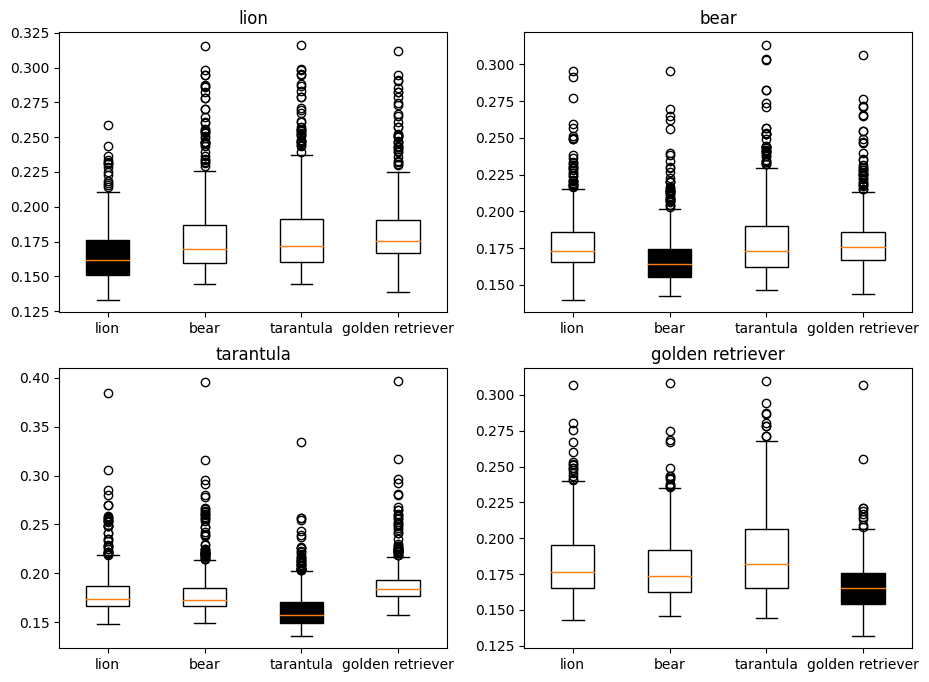

In [11]:
max_norm_sim = get_similarities(x, 'max_norm')
max_norm_scores, max_norm_average_scores = scores_dicts(max_norm_sim, subject_mapping)
plotting_boxplot(max_norm_scores)

In [12]:
max_norm_average_scores

{'lion': {'lion': tensor(0.1658),
  'bear': tensor(0.1785),
  'tarantula': tensor(0.1804),
  'golden retriever': tensor(0.1826)},
 'bear': {'lion': tensor(0.1785),
  'bear': tensor(0.1689),
  'tarantula': tensor(0.1807),
  'golden retriever': tensor(0.1796)},
 'tarantula': {'lion': tensor(0.1804),
  'bear': tensor(0.1807),
  'tarantula': tensor(0.1631),
  'golden retriever': tensor(0.1888)},
 'golden retriever': {'lion': tensor(0.1826),
  'bear': tensor(0.1796),
  'tarantula': tensor(0.1888),
  'golden retriever': tensor(0.1667)}}

In [29]:
get_thresholds(max_norm_average_scores)

[tensor(0.1549),
 tensor(0.1631),
 tensor(0.1658),
 tensor(0.1667),
 tensor(0.1689),
 tensor(0.1773)]

# City Block Show Case

c:\Users\97254\anaconda3\envs\project_lab\lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
4it [01:09, 

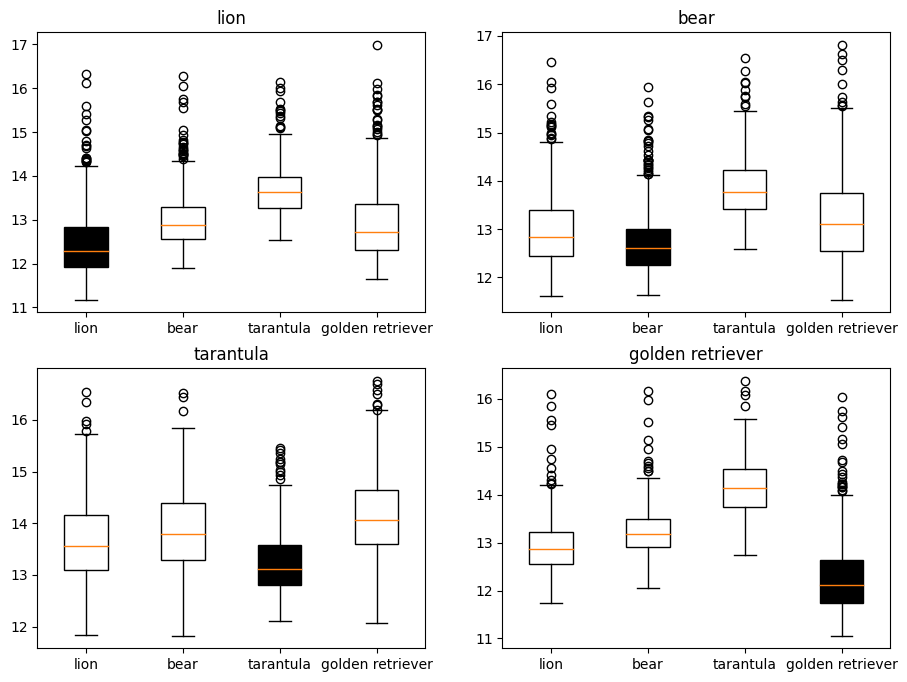

In [13]:
city_block_sim = get_similarities(x, 'city_block')
city_block_scores, city_block_average_scores = scores_dicts(city_block_sim, subject_mapping)
plotting_boxplot(city_block_scores)

In [14]:
city_block_average_scores

{'lion': {'lion': tensor(12.4717),
  'bear': tensor(12.9996),
  'tarantula': tensor(13.6666),
  'golden retriever': tensor(12.9313)},
 'bear': {'lion': tensor(12.9996),
  'bear': tensor(12.7226),
  'tarantula': tensor(13.8770),
  'golden retriever': tensor(13.2208)},
 'tarantula': {'lion': tensor(13.6666),
  'bear': tensor(13.8770),
  'tarantula': tensor(13.2242),
  'golden retriever': tensor(14.1547)},
 'golden retriever': {'lion': tensor(12.9313),
  'bear': tensor(13.2208),
  'tarantula': tensor(14.1547),
  'golden retriever': tensor(12.2903)}}

In [30]:
get_thresholds(city_block_average_scores)

[tensor(11.6758),
 tensor(12.2903),
 tensor(12.4717),
 tensor(12.7226),
 tensor(13.2242),
 tensor(13.8854)]

In [13]:
x, y, edges = construct_graph(data_df, ['chord', 0, 0.78])

Constructing Nodes...
Done.
Retrieving Labels...
Done.
Constructing edges based on: chord


100%|██████████| 2000/2000 [01:17<00:00, 25.89it/s]


Done, Graph is done constructing.


# Running the GNN

In [14]:
train_indeces = list(range(0,400)) + list(range(500,900)) + list(range(1000,1400)) + list(range(1500,1900))
valid_indeces = list(range(400,450)) + list(range(900,950)) + list(range(1400,1450)) + list(range(1900,1950))
test_indeces = list(range(450,500)) + list(range(950,1000)) + list(range(1450,1500)) + list(range(1950,2000))
train_mask = torch.tensor([1 if i in train_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if i in valid_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if i in test_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [15]:
data = Data(x=x, y=y, edge_index=edges, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)

In [16]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels//2, aggr="mean", normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//4, aggr="mean", normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, aggr="mean", normalize=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [17]:
output_dim = len(set(data.y.tolist()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, valid_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [19]:
best_val_acc = test_acc = 0
for epoch in tqdm(range(1,20)):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 1 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

  5%|▌         | 1/19 [00:09<02:44,  9.14s/it]

Epoch: 001, Val: 0.2500, Test: 0.2500


 11%|█         | 2/19 [00:18<02:32,  9.00s/it]

Epoch: 002, Val: 0.2650, Test: 0.2600


 16%|█▌        | 3/19 [00:26<02:20,  8.79s/it]

Epoch: 003, Val: 0.4700, Test: 0.4300


 21%|██        | 4/19 [00:35<02:11,  8.75s/it]

Epoch: 004, Val: 0.4900, Test: 0.4700


 26%|██▋       | 5/19 [00:44<02:02,  8.75s/it]

Epoch: 005, Val: 0.4900, Test: 0.4700


 32%|███▏      | 6/19 [00:52<01:51,  8.56s/it]

Epoch: 006, Val: 0.4900, Test: 0.4700


 37%|███▋      | 7/19 [01:00<01:43,  8.62s/it]

Epoch: 007, Val: 0.4900, Test: 0.4700


 42%|████▏     | 8/19 [01:09<01:33,  8.51s/it]

Epoch: 008, Val: 0.7000, Test: 0.6350


 47%|████▋     | 9/19 [01:17<01:25,  8.58s/it]

Epoch: 009, Val: 0.7000, Test: 0.6350


 53%|█████▎    | 10/19 [01:26<01:16,  8.54s/it]

Epoch: 010, Val: 0.7000, Test: 0.6350


 58%|█████▊    | 11/19 [01:34<01:08,  8.51s/it]

Epoch: 011, Val: 0.7500, Test: 0.6900


 63%|██████▎   | 12/19 [01:43<00:59,  8.47s/it]

Epoch: 012, Val: 0.7500, Test: 0.6900


 68%|██████▊   | 13/19 [01:51<00:50,  8.41s/it]

Epoch: 013, Val: 0.7500, Test: 0.6900


 74%|███████▎  | 14/19 [02:00<00:42,  8.49s/it]

Epoch: 014, Val: 0.7650, Test: 0.7100


 79%|███████▉  | 15/19 [02:12<00:38,  9.56s/it]

Epoch: 015, Val: 0.7650, Test: 0.7100


 84%|████████▍ | 16/19 [02:22<00:28,  9.66s/it]

Epoch: 016, Val: 0.8100, Test: 0.7550


 89%|████████▉ | 17/19 [02:30<00:18,  9.37s/it]

Epoch: 017, Val: 0.8100, Test: 0.7550


 95%|█████████▍| 18/19 [02:39<00:09,  9.16s/it]

Epoch: 018, Val: 0.8100, Test: 0.7550


100%|██████████| 19/19 [02:48<00:00,  8.86s/it]

Epoch: 019, Val: 0.8100, Test: 0.7550


In [6]:
from generate_results import *
import warnings 
warnings.filterwarnings('ignore')

get_accuracy(pd.read_csv('imagenet_embeddings.csv'), 'cosine', 1, 0.78, 1, [('mean', 2), ('mean', 3), ('max', 2), ('max', 3)], True)

Constructing Nodes...
Done.
Retrieving Labels...
Done.
Constructing edges based on: cosine


100%|██████████| 2000/2000 [00:06<00:00, 314.49it/s]


Done, Graph is done constructing.


100%|██████████| 100/100 [00:02<00:00, 38.41it/s]


('mean', 2)
[0.39, 0.8, 0.875, 0.875, 0.89, 0.905, 0.9, 0.885, 0.89, 0.9, 0.895] [0.395, 0.79, 0.86, 0.86, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875]


100%|██████████| 100/100 [00:02<00:00, 36.12it/s]


('mean', 3)
[0.455, 0.73, 0.865, 0.87, 0.87, 0.87, 0.865, 0.885, 0.865, 0.88, 0.88] [0.455, 0.705, 0.875, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]


100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


('max', 2)
[0.395, 0.68, 0.875, 0.875, 0.87, 0.895, 0.905, 0.895, 0.89, 0.9, 0.89] [0.43, 0.65, 0.87, 0.87, 0.87, 0.89, 0.885, 0.885, 0.885, 0.885, 0.885]


100%|██████████| 100/100 [00:05<00:00, 19.72it/s]

('max', 3)
[0.3, 0.77, 0.825, 0.865, 0.865, 0.88, 0.88, 0.875, 0.88, 0.885, 0.87] [0.305, 0.725, 0.815, 0.895, 0.895, 0.895, 0.895, 0.895, 0.895, 0.88, 0.88]


In [ ]:
import pandas as pd
from generate_results import *
import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('imagenet_embeddings.csv')

results = pd.DataFrame(columns=['Seed', 'Metric', 'Lower Threshold', 'Upper Threshold', 'Type Of Layers', 'Num of Layers', 'Validation', 'Test'])
gnn_types = [('mean', 2), ('mean', 3), ('max', 2), ('max', 3)]
seeds = [111, 222, 333, 444, 555]
scores = {'cosine': [(0.70, 1), (0.73, 1), (0.76, 1), (0.79, 1), (0.82, 1)]}
for score in scores.keys():
    for lower, upper in scores[score]:
        for seed in seeds:
            print(score, seed, lower, upper, gnn_types)
            validation_lst, test_lst = get_accuracy(data, score, seed, lower, upper, gnn_types)
            for gnn_type, val, test in zip(gnn_types, validation_lst, test_lst):
                results.loc[len(results)]= {'Seed': seed, 
                                            'Metric': score, 
                                            'Lower Threshold': lower, 
                                            'Upper Threshold': upper, 
                                            'Type Of Layers': gnn_type[0], 
                                            'Num of Layers': gnn_type[1], 
                                            'Validation': val, 
                                            'Test': test}

In [13]:
import pickle as pkl

with open('cosine_df.pkl', 'wb') as f:
            pkl.dump(results, f)

In [14]:
with open('cosine_df.pkl', 'rb') as f:
            test = pkl.load(f)
test

,Seed,Metric,Lower Threshold,Upper Threshold,Type Of Layers,Num of Layers,Validation,Test
0,111,cosine,0.70,1,mean,2,"[0.27, 0.755, 0.84, 0.865, 0.865, 0.875, 0.875...","[0.31, 0.755, 0.86, 0.885, 0.885, 0.89, 0.89, ..."
1,111,cosine,0.70,1,mean,3,"[0.335, 0.685, 0.81, 0.865, 0.875, 0.865, 0.87...","[0.33, 0.685, 0.805, 0.87, 0.895, 0.895, 0.895..."
2,111,cosine,0.70,1,max,2,"[0.39, 0.67, 0.755, 0.815, 0.88, 0.86, 0.88, 0...","[0.425, 0.675, 0.74, 0.84, 0.9, 0.9, 0.9, 0.9,..."
3,111,cosine,0.70,1,max,3,"[0.265, 0.65, 0.815, 0.83, 0.85, 0.865, 0.855,...","[0.28, 0.65, 0.78, 0.83, 0.87, 0.885, 0.885, 0..."
4,222,cosine,0.70,1,mean,2,"[0.335, 0.79, 0.855, 0.88, 0.885, 0.9, 0.905, ...","[0.28, 0.775, 0.85, 0.86, 0.88, 0.885, 0.885, ..."
...,...,...,...,...,...,...,...,...
95,444,cosine,0.82,1,max,3,"[0.37, 0.685, 0.875, 0.87, 0.905, 0.9, 0.9, 0....","[0.33, 0.625, 0.865, 0.865, 0.88, 0.88, 0.88, ..."
96,555,cosine,0.82,1,mean,2,"[0.405, 0.745, 0.845, 0.875, 0.9, 0.895, 0.89,...","[0.36, 0.76, 0.855, 0.905, 0.905, 0.905, 0.905..."
97,555,cosine,0.82,1,mean,3,"[0.25, 0.76, 0.815, 0.86, 0.87, 0.875, 0.88, 0...","[0.25, 0.785, 0.885, 0.9, 0.91, 0.885, 0.885, ..."
98,555,cosine,0.82,1,max,2,"[0.42, 0.69, 0.83, 0.865, 0.895, 0.9, 0.895, 0...","[0.355, 0.71, 0.875, 0.885, 0.905, 0.895, 0.89..."


# Euclidian

4it [00:20,  5.15s/it]


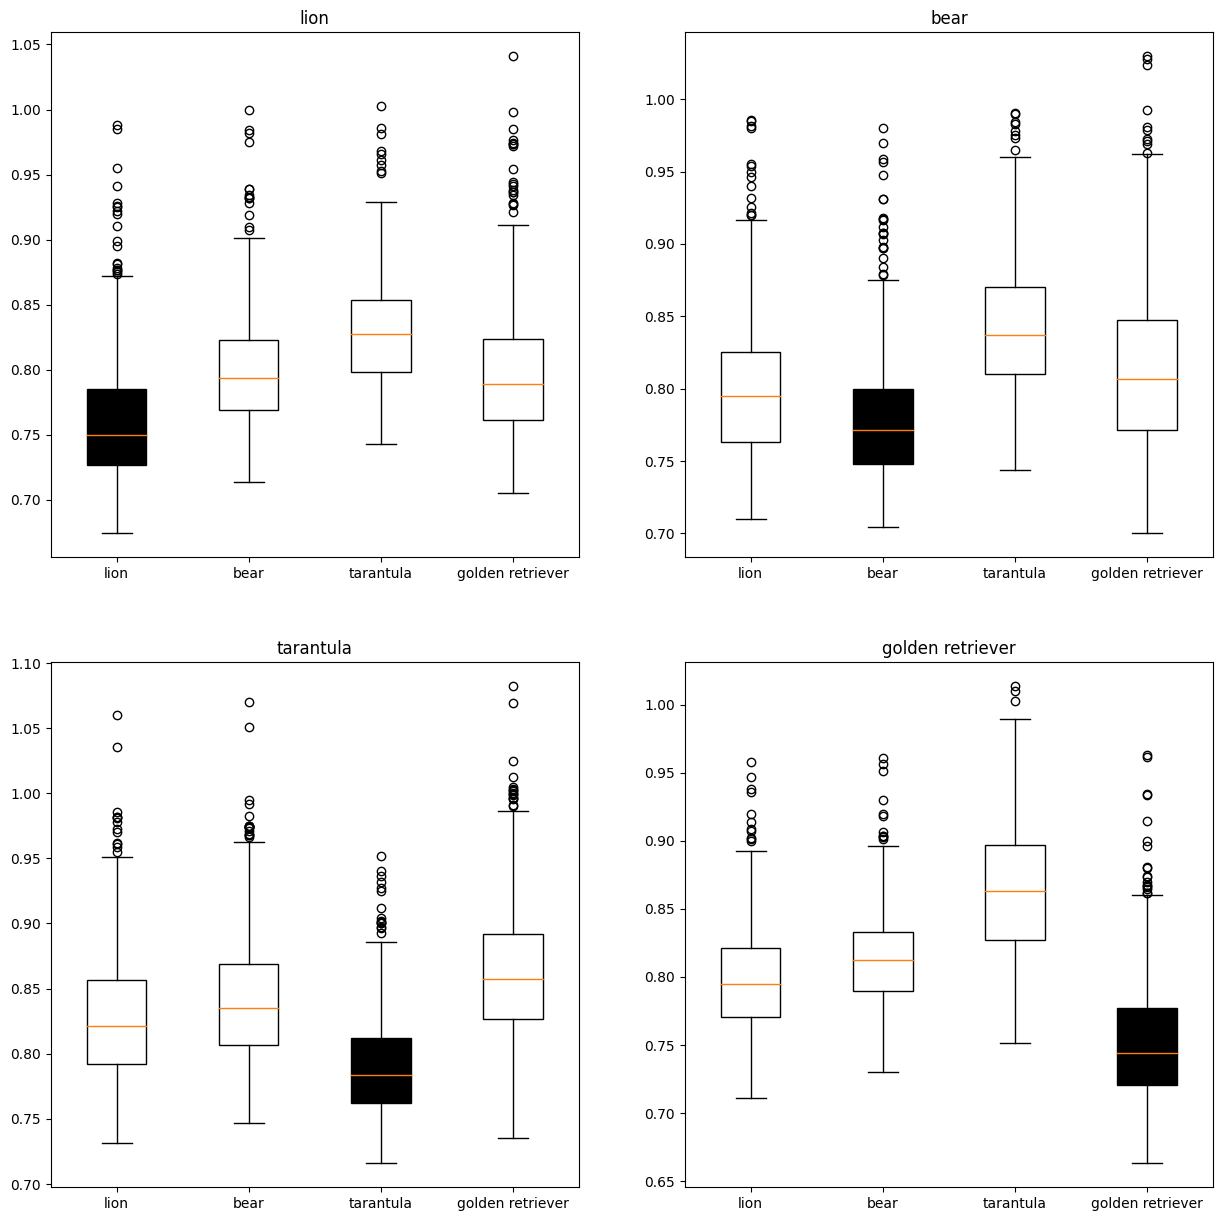

In [21]:
from generate_results import *
from scores_analysis import *

x  = construct_nodes(data)
subject_mapping = get_subject_mapping(data)
scores = get_metrics(x, True)
euclidian_scores, euclidian_averages = scores_dicts(scores['euclidian'], subject_mapping)
plotting_boxplot(euclidian_scores)

In [22]:
euclidian_averages

{'lion': {'lion': tensor(0.7612),
  'bear': tensor(0.7998),
  'tarantula': tensor(0.8296),
  'golden retriever': tensor(0.7984)},
 'bear': {'lion': tensor(0.7998),
  'bear': tensor(0.7804),
  'tarantula': tensor(0.8427),
  'golden retriever': tensor(0.8143)},
 'tarantula': {'lion': tensor(0.8296),
  'bear': tensor(0.8427),
  'tarantula': tensor(0.7908),
  'golden retriever': tensor(0.8637)},
 'golden retriever': {'lion': tensor(0.7984),
  'bear': tensor(0.8143),
  'tarantula': tensor(0.8637),
  'golden retriever': tensor(0.7537)}}

In [1]:
import pandas as pd
from generate_results import *
import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('imagenet_embeddings.csv')

results = pd.DataFrame(columns=['Seed', 'Metric', 'Lower Threshold', 'Upper Threshold', 'Type Of Layers', 'Num of Layers', 'Validation', 'Test'])
gnn_types = [('mean', 2), ('mean', 3), ('max', 2), ('max', 3)]
seeds = [111, 222, 333, 444, 555]
scores = {'euclidian': [(0, 0.8), (0, 0.78), (0, 0.76), (0, 0.74), (0, 0.72)]}
for score in scores.keys():
    for lower, upper in scores[score]:
        for seed in seeds:
            print(score, seed, lower, upper, gnn_types)
            validation_lst, test_lst = get_accuracy(data, score, seed, lower, upper, gnn_types)
            for gnn_type, val, test in zip(gnn_types, validation_lst, test_lst):
                results.loc[len(results)]= {'Seed': seed, 
                                            'Metric': score, 
                                            'Lower Threshold': lower, 
                                            'Upper Threshold': upper, 
                                            'Type Of Layers': gnn_type[0], 
                                            'Num of Layers': gnn_type[1], 
                                            'Validation': val, 
                                            'Test': test}

euclidian 111 0 0.8 [('mean', 2), ('mean', 3), ('max', 2), ('max', 3)]
Constructing Nodes...
Done.
Retrieving Labels...
Done.
Constructing edges based on: euclidian


100%|██████████| 2000/2000 [01:11<00:00, 28.00it/s]


Done, Graph is done constructing.
cuda


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


('mean', 2)
cuda


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


('mean', 3)
cuda


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 454.00 MiB (GPU 0; 7.93 GiB total capacity; 7.14 GiB already allocated; 314.88 MiB free; 7.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import pickle as pkl

with open('euclidian_df.pkl', 'wb') as f:
            pkl.dump(results, f)